# visualisation in spikeinterface and other tools

spikeinterface have many way to plot every steps (from pre to post processing) of a sorting.

Please have a look to this doc pages:

* https://spikeinterface.readthedocs.io/en/latest/modules/widgets.html
* https://spikeinterface.readthedocs.io/en/latest/viewers.html



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib widget

In [4]:
from pathlib import Path
import shutil
import numpy as np
import matplotlib.pyplot as plt

import spikeinterface.full as si
from probeinterface import generate_multi_columns_probe

In [8]:
base_folder = Path('.').resolve()

wf_folder = (base_folder / 'waveforms')


In [6]:
job_kwargs = dict(n_jobs=-1, chunk_duration='1s', progress_bar=True)

## lets generate a fake dataset

Here a simple way to generate a fake dataset


(-70.0, 120.0)

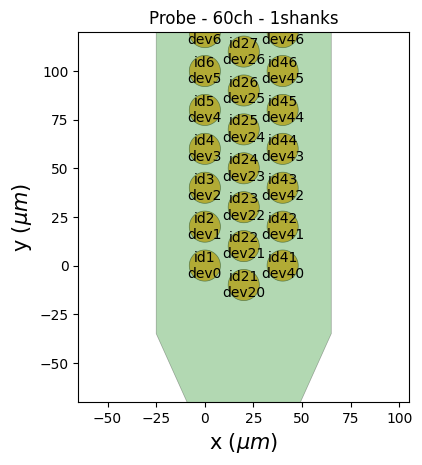

In [9]:
%matplotlib inline

# generate a fake probe
fig, ax = plt.subplots()
probe = generate_multi_columns_probe(
    num_columns=3,
    num_contact_per_column=20,
    xpitch=20,
    ypitch=20,
    y_shift_per_column=[0, -10, 0],
    contact_shapes="circle",
    contact_shape_params={"radius": 8},
    
)
probe.set_contact_ids([f'{i+1}' for i in range(probe.get_contact_count())])
probe.set_device_channel_indices(np.arange(probe.get_contact_count()))


from probeinterface.plotting import plot_probe
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)
ax.set_ylim(-70, 120)

In [11]:
rec, sorting = si.generate_ground_truth_recording(durations=[600.0],
                                                  sampling_frequency=30000.,
                                                  probe=probe,
                                                  num_units=120,
                                                  generate_sorting_kwargs={'firing_rates': 4, 'refractory_period_ms': 1.5},
                                                  generate_unit_locations_kwargs={'margin_um': 10.0, 'minimum_z': 10.0, 'maximum_z': 50.0},
                                                  seed=2205,
                                                 )
rec

InjectTemplatesRecording: 60 channels - 30.0kHz - 1 segments - 18,000,000 samples 
                          600.00s (10.00 minutes) - float32 dtype - 4.02 GiB

In [34]:


if wf_folder.exists():
    shutil.rmtree(wf_folder)

we = si.extract_waveforms(recording=rec, sorting=sorting, folder=wf_folder, sparse=True, **job_kwargs)
si.compute_correlograms(we)
si.compute_unit_locations(we)
si.compute_spike_amplitudes(we, **job_kwargs)
si.compute_template_similarity(we)
si.compute_spike_locations(we)

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/600 [00:00<?, ?it/s]

array([(20.97231667,  27.60053734), (24.1029714 , 179.28241278),
       (22.15637713,  98.62171471), ..., (21.06758944, 282.28032154),
       (19.72267671, 193.39754374), (19.63230118, 179.86284029)],
      dtype=[('x', '<f8'), ('y', '<f8')])

In [36]:
we

WaveformExtractor: 60 channels - 120 units - 1 segments
  before:90 after:120 n_per_units:500 - sparse

##  visualisation with module widget - backend="matplotlib"

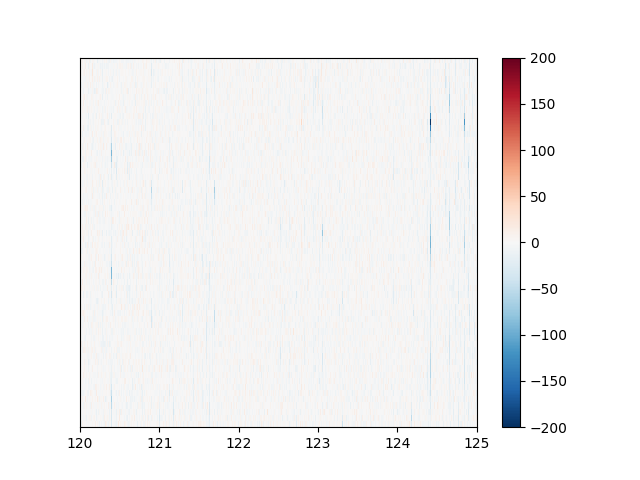

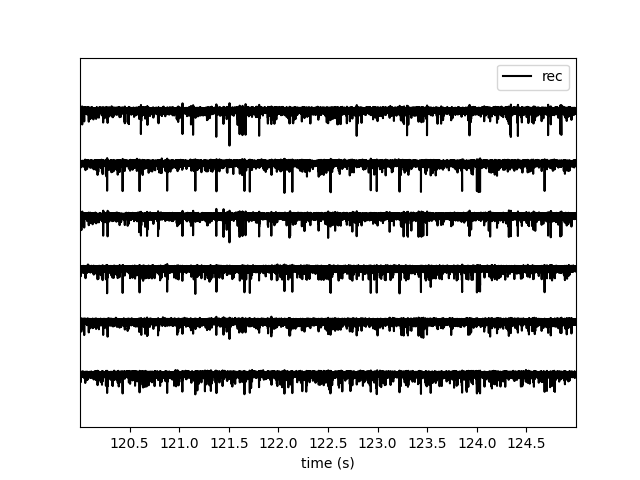

In [37]:
si.plot_traces(rec, time_range=(120, 125), mode='map', backend='matplotlib')
si.plot_traces(rec, time_range=(120, 125), mode='line', channel_ids=rec.channel_ids[::10])

##  visualisation with module widget - backend="ipywidgets"

In [12]:
%matplotlib widget
si.plot_traces(rec, time_range=(120, 125), mode='map', backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## multi layer

In [13]:
%matplotlib widget
rec_processed = si.bandpass_filter(rec, freq_min=300., freq_max = 4000.)
si.plot_traces({'raw': rec, 'processed': rec_processed}, time_range=(10, 10.02),
               mode='line',
               backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

##  visualisation with module widget - backend="sortingview"

In [14]:
rec_processed = si.bandpass_filter(rec, freq_min=300., freq_max = 4000.)
si.plot_traces({'raw': rec, 'processed': rec_processed}, time_range=(10, 10.5),
               mode='map', order_channel_by_depth=True,
               backend='sortingview')

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://5599e791fc82ccf4ff1c82f1f8d2f3f449da3453


##  visualisation with module widget - backend="ephyviewer"

In [41]:
w = si.plot_traces(rec, mode='line', backend='ephyviewer')

KeyError: '__class__'

## postprocessing

In [10]:
we = si.load_waveforms(wf_folder)

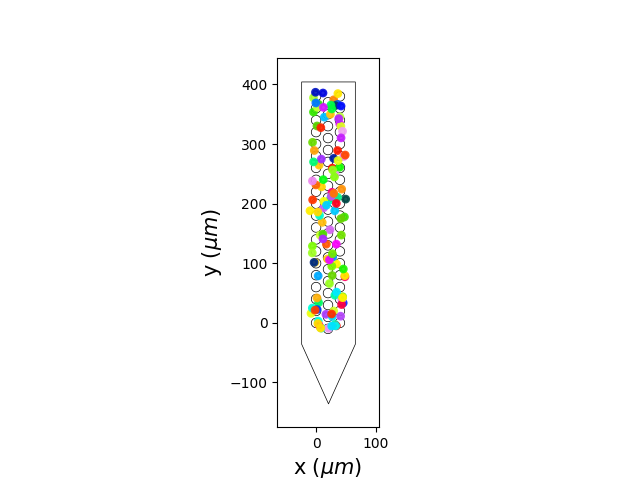

In [43]:
si.plot_unit_locations(we)

In [44]:
%matplotlib widget
# si.plot_unit_waveforms(we, backend='matplotlib')
si.plot_unit_waveforms(we, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

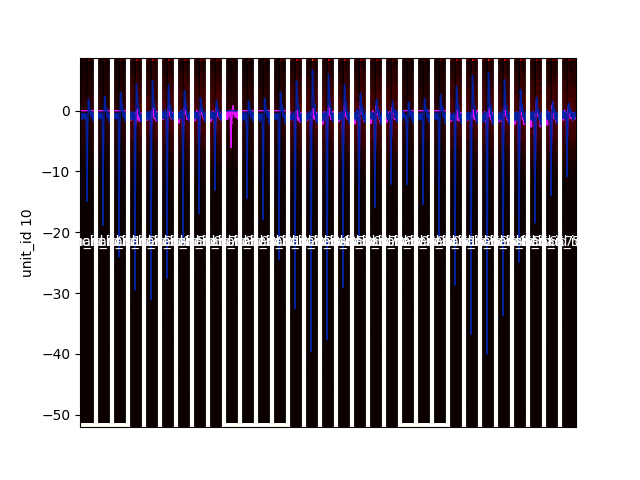

In [45]:
%matplotlib widget
si.plot_unit_waveforms_density_map(we, backend='matplotlib', unit_ids=we.unit_ids[10:12], same_axis=True)

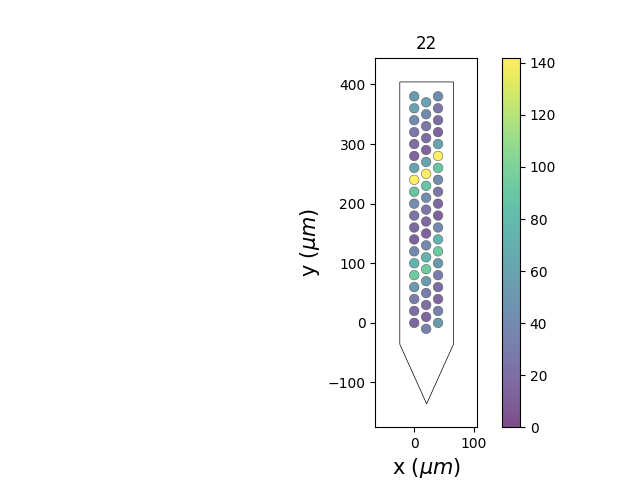

In [46]:
%matplotlib widget
si.plot_unit_probe_map(we,unit_ids=we.unit_ids[22:23])

In [47]:
%matplotlib widget
si.plot_amplitudes(we,unit_ids=we.unit_ids[22:23], backend='ipywidgets')

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

In [48]:
%matplotlib widget
si.plot_spike_locations(we, backend='ipywidgets')

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

## Summary with spikeinterface-gui

In [49]:
!sigui {wf_older}

Traceback (most recent call last):
  File "/home/samuel/.virtualenvs/py3.10/bin/sigui", line 8, in <module>
    sys.exit(run_mainwindow_cli())
  File "/home/samuel/Documents/SpikeInterface/spikeinterface-gui/spikeinterface_gui/main.py", line 34, in run_mainwindow_cli
    run_mainwindow(waveform_folder)
  File "/home/samuel/Documents/SpikeInterface/spikeinterface-gui/spikeinterface_gui/main.py", line 14, in run_mainwindow
    we = WaveformExtractor.load_from_folder(waveform_folder)
  File "/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/waveform_extractor.py", line 142, in load_from_folder
    assert folder.is_dir(), f"This waveform folder does not exists {folder}"
AssertionError: This waveform folder does not exists {wf_older}


## Summary with sorting view

In [16]:
si.plot_sorting_summary(we, backend='sortingview')

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://9c0356e0f47c19777b4fbceb35852687f0017fe0


## export to phy

phy used to be areference for manual curation but this is not maintened anymore.

In [16]:
phy_folder = (base_folder / 'phy_folder')

if not phy_folder.exists():
    si.export_to_phy(we, output_folder=phy_folder,
                     compute_pc_features=False,
                     compute_amplitudes=True,
                     copy_binary=False,
                     **job_kwargs)

    
    

Run:
phy template-gui  /home/samuel/Documents/SpikeInterface/school_spike_sorting_marseille_2023/Practice_visualisation/phy_folder/params.py


In [ ]:
! phy template-gui  {phy_folder}/params.py